## Intro
In this notebook I will be using the encoder/decoder structure with an rnn to learn addition. While this is not the machine translation we have been doing in class I thought this was a super cool use-case of the same structure. 

The majority of the code to build/train the model I found from the link https://github.com/keras-team/keras-io/blob/master/examples/nlp/addition_rnn.py

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
#3 digits addition
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True
MAXLEN = DIGITS + 1 + DIGITS

The procedure here is pretty simple. We will encode the set on integers into a one-hot vector. Then we will decode this vector to get the character output. 

In [3]:
class CharacterTable:
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[x] for x in x)

The possible characters we care about are all the integers as well as "+" and " " (a space for padding).

In [4]:
chars = "0123456789+ "
ctable = CharacterTable(chars)

Now we must generate data in order to train and test the model

In [5]:
questions = []
expected = []
seen = set()
print("Generating data...")
while len(questions) < TRAINING_SIZE:
    f = lambda: int(
        "".join(
            np.random.choice(list("0123456789"))
            for i in range(np.random.randint(1, DIGITS + 1))
        )
    )
    a, b = f(), f()
    # Skip any addition that has already been made as well as the same problem but reversed (1+2 = 2+1)
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    #Add padding so that the string is always the same length
    q = "{}+{}".format(a, b)
    query = q + " " * (MAXLEN - len(q))
    ans = str(a + b)
    ans += " " * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the problem (123 + 456 = 654+321)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print("Total questions:", len(questions))

Generating data...
Total questions: 50000


Now we need to vectorize the data 

In [6]:
print("Vectorization...")
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print("Training Data:")
print(x_train.shape)
print(y_train.shape)

print("Validation Data:")
print(x_val.shape)
print(y_val.shape)

Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)


In [7]:
#show what the data looks like now
x_train[0]

array([[ True, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False,  True, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False,  True],
       [False, False, False,  True, False, False, False, False, False,
        False, False, False],
       [False,  True, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False,  True, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False,  True, False]])

In [24]:
print("Build model...")
num_layers = 1 
model = keras.Sequential()
model.add(layers.LSTM(128, input_shape=(MAXLEN, len(chars))))

model.add(layers.RepeatVector(DIGITS + 1))

for _ in range(num_layers):
    model.add(layers.LSTM(128, return_sequences=True))

model.add(layers.Dense(len(chars), activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Build model...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
dense_4 (Dense)              (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


When training the model it would be cool to see the models performance past just the metrics of accuracy, val_accuracy, loss, and val_loss. To do this, I loop across a certain amount of epochs and each time I run one epoch and make the model predict 10 additions. Thus, we are able to see what the model is predicting after each epoch. I also print out the number of correct guesses after each epoch.

In [25]:
his = []
epochs = 30
batch_size = 32
correct_guesses = []
for epoch in range(1, epochs):
    print()
    print("Epoch", epoch)
    print()
    #Train the model 1 epoch at a time
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=(x_val, y_val),
    )
    #add results to array
    his.append(history)
    # Select 50 samples from the validation set at random so we can visualize errors.
    count = 0
    for i in range(50):
        
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = np.argmax(model.predict(rowx), axis=-1)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print("Q", q[::-1] if REVERSE else q, end=" ")
        print("T", correct, end=" ")
        if correct == guess:
            count += 1
            print("correct", guess)
        else:
            print("incorrect", guess)
    print("Number of correct guesses:", count)
    correct_guesses.append(count)


Epoch 1

1407/1407 [==============================] - 13s 8ms/step - loss: 1.8896 - accuracy: 0.3222 - val_loss: 1.5538 - val_accuracy: 0.4134
Q 698+24  T 722  incorrect 872 
Q 78+49   T 127  incorrect 103 
Q 130+354 T 484  incorrect 477 
Q 575+517 T 1092 incorrect 107 
Q 54+341  T 395  incorrect 457 
Q 58+527  T 585  incorrect 577 
Q 46+42   T 88   incorrect 46  
Q 827+53  T 880  incorrect 903 
Q 909+166 T 1075 incorrect 100 
Q 317+622 T 939  incorrect 107 
Q 2+825   T 827  incorrect 21  
Q 4+289   T 293  incorrect 100 
Q 11+184  T 195  incorrect 11  
Q 662+4   T 666  incorrect 767 
Q 6+243   T 249  incorrect 437 
Q 428+1   T 429  incorrect 118 
Q 29+29   T 58   incorrect 21  
Q 48+998  T 1046 incorrect 100 
Q 410+0   T 410  incorrect 118 
Q 98+202  T 300  incorrect 397 
Q 950+66  T 1016 incorrect 100 
Q 79+959  T 1038 incorrect 100 
Q 821+783 T 1604 incorrect 1570
Q 161+723 T 884  incorrect 107 
Q 89+99   T 188  incorrect 900 
Q 815+810 T 1625 incorrect 1577
Q 714+71  T 785  incorre

Q 0+328   T 328  incorrect 329 
Q 50+244  T 294  incorrect 291 
Q 523+88  T 611  correct 611 
Q 56+81   T 137  incorrect 136 
Q 99+335  T 434  incorrect 421 
Q 394+4   T 398  incorrect 399 
Q 539+77  T 616  correct 616 
Q 34+374  T 408  incorrect 416 
Q 951+88  T 1039 incorrect 1030
Q 81+972  T 1053 incorrect 1040
Q 0+311   T 311  correct 311 
Q 826+29  T 855  incorrect 851 
Q 59+645  T 704  incorrect 701 
Q 25+489  T 514  incorrect 519 
Q 72+621  T 693  incorrect 791 
Q 5+95    T 100  incorrect 10  
Q 194+20  T 214  incorrect 211 
Q 79+61   T 140  incorrect 149 
Q 737+72  T 809  incorrect 801 
Number of correct guesses: 8

Epoch 6

1407/1407 [==============================] - 13s 9ms/step - loss: 0.6791 - accuracy: 0.7516 - val_loss: 0.6679 - val_accuracy: 0.7506
Q 6+268   T 274  correct 274 
Q 30+805  T 835  incorrect 838 
Q 470+259 T 729  incorrect 727 
Q 249+76  T 325  incorrect 324 
Q 834+0   T 834  correct 834 
Q 71+533  T 604  correct 604 
Q 56+820  T 876  incorrect 870 
Q 802+9

Q 903+58  T 961  correct 961 
Q 90+919  T 1009 correct 1009
Q 18+523  T 541  correct 541 
Q 368+807 T 1175 correct 1175
Q 348+302 T 650  correct 650 
Q 10+608  T 618  correct 618 
Q 90+97   T 187  correct 187 
Q 479+926 T 1405 correct 1405
Q 2+413   T 415  correct 415 
Q 961+598 T 1559 correct 1559
Q 792+32  T 824  correct 824 
Q 470+68  T 538  correct 538 
Q 1+375   T 376  correct 376 
Q 49+476  T 525  correct 525 
Q 1+876   T 877  correct 877 
Q 78+561  T 639  incorrect 649 
Q 114+35  T 149  correct 149 
Q 564+409 T 973  correct 973 
Q 90+85   T 175  correct 175 
Q 59+463  T 522  correct 522 
Q 222+51  T 273  correct 273 
Q 346+989 T 1335 correct 1335
Q 199+27  T 226  correct 226 
Q 481+95  T 576  correct 576 
Q 871+6   T 877  correct 877 
Q 19+839  T 858  correct 858 
Q 694+35  T 729  correct 729 
Q 39+39   T 78   incorrect 88  
Q 4+649   T 653  correct 653 
Q 697+9   T 706  correct 706 
Q 948+9   T 957  correct 957 
Q 126+915 T 1041 correct 1041
Number of correct guesses: 48

Epoch

Q 821+783 T 1604 correct 1604
Q 492+741 T 1233 correct 1233
Q 676+98  T 774  correct 774 
Q 94+734  T 828  correct 828 
Q 86+668  T 754  correct 754 
Q 847+70  T 917  correct 917 
Q 279+581 T 860  correct 860 
Q 900+63  T 963  correct 963 
Q 93+684  T 777  correct 777 
Q 641+34  T 675  correct 675 
Q 53+43   T 96   correct 96  
Q 440+813 T 1253 correct 1253
Q 761+5   T 766  correct 766 
Q 66+25   T 91   correct 91  
Q 48+169  T 217  correct 217 
Q 3+14    T 17   correct 17  
Q 16+40   T 56   correct 56  
Q 947+530 T 1477 correct 1477
Q 708+8   T 716  correct 716 
Q 3+768   T 771  correct 771 
Q 775+72  T 847  correct 847 
Q 24+41   T 65   correct 65  
Q 219+82  T 301  correct 301 
Q 595+81  T 676  correct 676 
Q 0+851   T 851  correct 851 
Q 229+394 T 623  correct 623 
Q 11+759  T 770  correct 770 
Q 2+957   T 959  correct 959 
Q 413+572 T 985  correct 985 
Q 9+604   T 613  correct 613 
Q 657+722 T 1379 correct 1379
Q 927+83  T 1010 correct 1010
Q 640+29  T 669  correct 669 
Q 526+599 

Q 535+972 T 1507 correct 1507
Q 834+0   T 834  correct 834 
Q 775+78  T 853  correct 853 
Q 185+2   T 187  correct 187 
Q 77+805  T 882  correct 882 
Q 270+606 T 876  correct 876 
Q 212+5   T 217  correct 217 
Q 822+688 T 1510 correct 1510
Q 1+373   T 374  correct 374 
Q 768+34  T 802  correct 802 
Q 94+752  T 846  correct 846 
Q 61+483  T 544  correct 544 
Q 936+556 T 1492 correct 1492
Q 936+961 T 1897 correct 1897
Q 75+673  T 748  correct 748 
Q 966+61  T 1027 correct 1027
Q 617+34  T 651  correct 651 
Q 66+692  T 758  correct 758 
Q 221+717 T 938  correct 938 
Q 936+620 T 1556 correct 1556
Q 384+40  T 424  correct 424 
Q 902+5   T 907  correct 907 
Q 31+411  T 442  correct 442 
Q 861+7   T 868  correct 868 
Q 371+291 T 662  correct 662 
Q 97+220  T 317  correct 317 
Q 739+12  T 751  correct 751 
Q 890+319 T 1209 correct 1209
Q 355+59  T 414  correct 414 
Q 90+471  T 561  incorrect 551 
Q 483+3   T 486  correct 486 
Q 50+708  T 758  correct 758 
Q 9+473   T 482  correct 482 
Q 14+356

Q 9+669   T 678  correct 678 
Q 78+387  T 465  correct 465 
Q 378+78  T 456  correct 456 
Q 858+7   T 865  correct 865 
Q 377+976 T 1353 correct 1353
Q 892+34  T 926  correct 926 
Q 976+71  T 1047 correct 1047
Q 81+398  T 479  correct 479 
Q 183+54  T 237  correct 237 
Q 12+837  T 849  correct 849 
Q 95+464  T 559  incorrect 569 
Q 476+722 T 1198 correct 1198
Q 4+900   T 904  correct 904 
Q 712+5   T 717  correct 717 
Q 193+406 T 599  correct 599 
Q 689+0   T 689  correct 689 
Q 768+1   T 769  correct 769 
Q 165+933 T 1098 correct 1098
Q 427+96  T 523  correct 523 
Q 366+981 T 1347 correct 1347
Q 1+321   T 322  correct 322 
Q 426+83  T 509  correct 509 
Q 534+22  T 556  correct 556 
Q 807+694 T 1501 correct 1501
Q 658+6   T 664  correct 664 
Q 853+13  T 866  correct 866 
Q 139+0   T 139  correct 139 
Q 934+7   T 941  correct 941 
Q 145+9   T 154  correct 154 
Q 984+70  T 1054 correct 1054
Q 63+68   T 131  correct 131 
Q 8+513   T 521  correct 521 
Q 73+410  T 483  correct 483 
Q 536+38

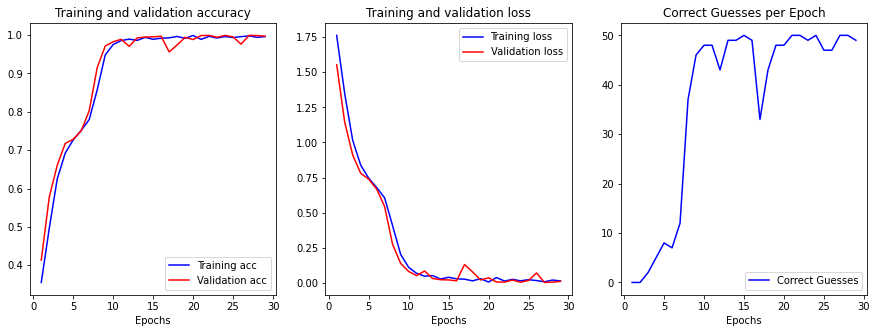

In [26]:
# Plot to visualize accuracy, loss, and correct guesses
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def plot_history(history):
    acc = [his[i].history["accuracy"][0] for i in range (0,len(his))]
    val_acc = [his[i].history["val_accuracy"][0] for i in range (0,len(his))]
    loss = [his[i].history["loss"][0] for i in range (0,len(his))]
    val_loss = [his[i].history["val_loss"][0] for i in range (0,len(his))]

    x = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.xlabel("Epochs")
    plt.legend()
    plt.title('Training and validation loss')
    
    plt.subplot(1, 3, 3)
    plt.plot(x, correct_guesses, 'b', label='Correct Guesses')
    plt.xlabel("Epochs")
    plt.title('Correct Guesses per Epoch')
    plt.legend()
    
plot_history(his)

The above plots are pretty much what I would have expected to see. I am impressed at how good the model ends up being. The accuracy is very close to 1 after about 10 epochs and the loss is very close to 0 after the same amount of epochs. Additionally, the number of correct guesses makes a big jump to 45-50 around the same number of epochs.

I wanted to change the number of LSTM layers in the model to see if there would be any significant differences in the number of epochs at which the model becomes profficient but due the the increase in time it takes to train a model with more layers I only double the amount. I am not expecting to see much of a difference but curiousity drives me to at least test this.

In [21]:
print("Build model...")
num_layers = 2 
model = keras.Sequential()
model.add(layers.LSTM(128, input_shape=(MAXLEN, len(chars))))

model.add(layers.RepeatVector(DIGITS + 1))

for _ in range(num_layers):
    model.add(layers.LSTM(128, return_sequences=True))

model.add(layers.Dense(len(chars), activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Build model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128)               72192     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
lstm_13 (LSTM)               (None, 4, 128)            131584    
_________________________________________________________________
dense_3 (Dense)              (None, 4, 12)             1548      
Total params: 336,908
Trainable params: 336,908
Non-trainable params: 0
_________________________________________________________________


In [22]:
his = []
epochs = 30
batch_size = 32
correct_guesses = []
for epoch in range(1, epochs):
    print()
    print("Epoch", epoch)
    print()
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=(x_val, y_val),
    )
    his.append(history)
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    count = 0
    for i in range(50):
        
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = np.argmax(model.predict(rowx), axis=-1)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print("Q", q[::-1] if REVERSE else q, end=" ")
        print("T", correct, end=" ")
        if correct == guess:
            count += 1
            print("correct", guess)
        else:
            print("incorrect", guess)
    print("Number of correct guesses:", count)
    correct_guesses.append(count)


Epoch 1

1407/1407 [==============================] - 17s 10ms/step - loss: 1.9037 - accuracy: 0.3194 - val_loss: 1.5583 - val_accuracy: 0.4093
Q 0+121   T 121  incorrect 112 
Q 51+629  T 680  incorrect 515 
Q 53+192  T 245  incorrect 215 
Q 117+5   T 122  incorrect 215 
Q 657+161 T 818  incorrect 705 
Q 342+72  T 414  incorrect 545 
Q 882+3   T 885  incorrect 795 
Q 451+560 T 1011 incorrect 101 
Q 157+628 T 785  incorrect 705 
Q 549+14  T 563  incorrect 545 
Q 51+911  T 962  incorrect 905 
Q 533+60  T 593  incorrect 575 
Q 28+993  T 1021 incorrect 901 
Q 517+366 T 883  incorrect 705 
Q 88+924  T 1012 incorrect 101 
Q 77+717  T 794  incorrect 895 
Q 82+609  T 691  incorrect 795 
Q 161+13  T 174  incorrect 215 
Q 754+7   T 761  incorrect 775 
Q 771+346 T 1117 incorrect 1111
Q 369+533 T 902  incorrect 705 
Q 624+81  T 705  incorrect 795 
Q 777+48  T 825  incorrect 705 
Q 95+560  T 655  incorrect 795 
Q 304+54  T 358  incorrect 445 
Q 617+3   T 620  incorrect 575 
Q 274+341 T 615  incorr

Q 739+675 T 1414 incorrect 1411
Q 918+43  T 961  incorrect 969 
Q 30+673  T 703  incorrect 709 
Q 276+97  T 373  incorrect 371 
Q 191+930 T 1121 incorrect 1101
Q 6+896   T 902  incorrect 901 
Q 822+0   T 822  incorrect 827 
Q 71+77   T 148  incorrect 141 
Q 37+163  T 200  incorrect 201 
Q 89+569  T 658  incorrect 657 
Q 564+8   T 572  incorrect 577 
Q 542+48  T 590  incorrect 599 
Q 425+77  T 502  incorrect 501 
Number of correct guesses: 2

Epoch 6

1407/1407 [==============================] - 14s 10ms/step - loss: 0.8064 - accuracy: 0.6930 - val_loss: 0.8083 - val_accuracy: 0.6885
Q 6+879   T 885  incorrect 889 
Q 342+72  T 414  incorrect 410 
Q 28+278  T 306  incorrect 309 
Q 903+599 T 1502 incorrect 1417
Q 888+361 T 1249 incorrect 1240
Q 881+601 T 1482 incorrect 1497
Q 230+882 T 1112 incorrect 1121
Q 332+4   T 336  correct 336 
Q 52+663  T 715  incorrect 713 
Q 62+907  T 969  incorrect 970 
Q 808+635 T 1443 incorrect 1433
Q 738+845 T 1583 incorrect 1580
Q 97+37   T 134  incorrect 1

Q 25+428  T 453  incorrect 456 
Q 14+21   T 35   incorrect 36  
Q 978+181 T 1159 incorrect 1162
Q 234+134 T 368  incorrect 370 
Q 8+632   T 640  incorrect 649 
Q 93+125  T 218  incorrect 210 
Q 710+119 T 829  incorrect 837 
Q 906+95  T 1001 incorrect 990 
Q 23+782  T 805  incorrect 800 
Q 683+447 T 1130 incorrect 1132
Q 79+959  T 1038 incorrect 1030
Q 8+50    T 58   incorrect 52  
Q 61+657  T 718  incorrect 710 
Q 271+479 T 750  incorrect 756 
Q 195+248 T 443  incorrect 446 
Q 481+27  T 508  incorrect 500 
Q 178+46  T 224  incorrect 222 
Q 663+621 T 1284 incorrect 1281
Q 287+73  T 360  incorrect 362 
Q 35+344  T 379  incorrect 370 
Q 809+861 T 1670 incorrect 1672
Q 222+51  T 273  incorrect 278 
Q 712+319 T 1031 incorrect 1037
Q 816+23  T 839  correct 839 
Q 13+226  T 239  incorrect 236 
Q 224+775 T 999  incorrect 990 
Q 2+451   T 453  incorrect 450 
Q 362+1   T 363  incorrect 366 
Q 796+664 T 1460 incorrect 1462
Q 41+902  T 943  incorrect 940 
Q 847+48  T 895  incorrect 890 
Number of 

Q 39+900  T 939  correct 939 
Q 67+422  T 489  correct 489 
Q 47+580  T 627  correct 627 
Q 81+64   T 145  correct 145 
Q 575+32  T 607  correct 607 
Q 479+54  T 533  correct 533 
Q 22+334  T 356  incorrect 359 
Q 14+438  T 452  correct 452 
Q 420+649 T 1069 correct 1069
Q 33+573  T 606  correct 606 
Q 178+47  T 225  correct 225 
Q 423+418 T 841  incorrect 842 
Q 661+401 T 1062 correct 1062
Q 50+943  T 993  correct 993 
Q 5+45    T 50   incorrect 40  
Q 72+965  T 1037 incorrect 1038
Q 660+49  T 709  incorrect 719 
Q 31+872  T 903  correct 903 
Q 94+752  T 846  correct 846 
Q 96+690  T 786  correct 786 
Q 997+64  T 1061 incorrect 1071
Q 208+504 T 712  incorrect 711 
Q 37+461  T 498  correct 498 
Q 480+96  T 576  correct 576 
Q 863+67  T 930  correct 930 
Q 51+629  T 680  correct 680 
Q 956+73  T 1029 correct 1029
Q 763+799 T 1562 incorrect 1461
Q 9+888   T 897  incorrect 896 
Q 44+412  T 456  correct 456 
Q 166+92  T 258  incorrect 257 
Q 373+98  T 471  incorrect 472 
Q 372+508 T 880  c

1407/1407 [==============================] - 16s 11ms/step - loss: 0.0384 - accuracy: 0.9892 - val_loss: 0.0141 - val_accuracy: 0.9964
Q 278+630 T 908  incorrect 808 
Q 16+46   T 62   correct 62  
Q 569+802 T 1371 correct 1371
Q 38+29   T 67   correct 67  
Q 372+424 T 796  correct 796 
Q 172+21  T 193  correct 193 
Q 0+258   T 258  correct 258 
Q 373+911 T 1284 correct 1284
Q 75+40   T 115  correct 115 
Q 54+156  T 210  correct 210 
Q 486+655 T 1141 correct 1141
Q 0+303   T 303  correct 303 
Q 625+70  T 695  correct 695 
Q 81+189  T 270  correct 270 
Q 50+244  T 294  correct 294 
Q 482+7   T 489  correct 489 
Q 998+892 T 1890 incorrect 1880
Q 237+4   T 241  correct 241 
Q 583+281 T 864  correct 864 
Q 605+96  T 701  correct 701 
Q 217+140 T 357  correct 357 
Q 14+21   T 35   correct 35  
Q 799+59  T 858  correct 858 
Q 955+716 T 1671 correct 1671
Q 178+569 T 747  correct 747 
Q 94+706  T 800  correct 800 
Q 205+15  T 220  correct 220 
Q 228+551 T 779  correct 779 
Q 780+23  T 803  corr

Q 222+377 T 599  correct 599 
Q 80+708  T 788  correct 788 
Q 60+908  T 968  correct 968 
Q 41+657  T 698  correct 698 
Q 425+77  T 502  correct 502 
Number of correct guesses: 48

Epoch 25

1407/1407 [==============================] - 16s 11ms/step - loss: 0.0325 - accuracy: 0.9903 - val_loss: 0.0315 - val_accuracy: 0.9894
Q 79+705  T 784  correct 784 
Q 413+572 T 985  correct 985 
Q 268+20  T 288  correct 288 
Q 528+38  T 566  correct 566 
Q 39+299  T 338  correct 338 
Q 457+131 T 588  correct 588 
Q 489+55  T 544  correct 544 
Q 496+80  T 576  correct 576 
Q 861+7   T 868  correct 868 
Q 716+2   T 718  correct 718 
Q 168+34  T 202  incorrect 292 
Q 58+1    T 59   correct 59  
Q 2+604   T 606  correct 606 
Q 21+67   T 88   correct 88  
Q 1+429   T 430  correct 430 
Q 184+3   T 187  correct 187 
Q 794+1   T 795  correct 795 
Q 527+4   T 531  correct 531 
Q 729+616 T 1345 correct 1345
Q 99+929  T 1028 correct 1028
Q 868+808 T 1676 correct 1676
Q 42+840  T 882  correct 882 
Q 27+35   T 

Q 0+379   T 379  correct 379 
Q 107+85  T 192  correct 192 
Q 7+775   T 782  correct 782 
Q 63+139  T 202  correct 202 
Q 306+574 T 880  correct 880 
Q 12+92   T 104  correct 104 
Q 16+176  T 192  correct 192 
Q 783+55  T 838  correct 838 
Number of correct guesses: 50


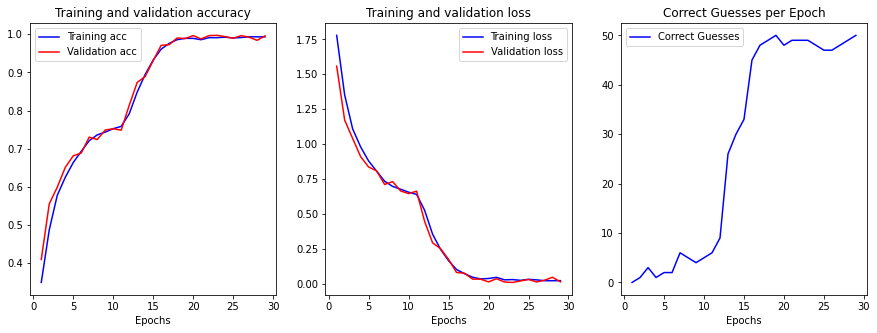

In [23]:
plot_history(his)

Well I can say that this is absolutely not what I was expecting. There is a clear initial jump in the accuracy but then it seems to level out for almost 10 epochs only to jump up again. The inverse is true for the loss. Also, it actually takes slightly more epochs to reach the first 10 correct guesses than before. However, it seems like once it gets there it is actually more consistent in getting all 10 correct than the previous model. Granted 50 data points is not that many in the grand scheme of things but this seems to be significant since from epochs ~15 on, there is only one time it does not perform perfectly. 

In retrospect, it is probably naive of me to assume by adding an extra layer that the model would improve initially. Adding complexity to a model does not necessarily make it better.

## Final Thoughts
When I first ran across this code I found it fascinating that you could create a model to perform addition using the same structure as the machine translations from one language to another. But the more I thought about this the more it made sense. We are doing the same thing as translating from one language to another but in this case the language isnt something people speak. In this case, the languages are of the form "123+456" and "579". We are pre programmed as humans who have gone through education to treate this as a math problem but you can also look at it as a translation from one language of the form "xxx+xxx" to another language of the form "xxx".